In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm
from dataclasses import dataclass
from typing import List
from collections import defaultdict

In [2]:
@dataclass
class Racetrack:
    starting_line: List[List[int]]
    finish_line: List[List[int]]
    track_boundary: List[List[int]]

    def __post_init__(self):
        # self.track_boundary += self.starting_line + self.finish_line
        self.starting_line_np = np.array(self.starting_line)
        self.finish_line_np = np.array(self.finish_line)
        self.track_boundary_np = np.array(self.track_boundary)
        all_coords = np.vstack([self.starting_line_np, self.finish_line_np, self.track_boundary_np])
        self.max_x =  max(all_coords[:,0])
        self.max_y =  max(all_coords[:,1])

    def check_boundary_intersection(self, points: np.ndarray):
        for point in points:
            if point in self.track_boundary:
                # print(f'Boundary:{point}')
                return True

        return False
    
    def check_finish_line_intersection(self, points: np.ndarray):
        for point in points:
            if point in self.finish_line:
                # print(f'Finish:{point}')
                return True
        return False
    
    def draw_start_point(self):
        return self.starting_line[np.random.randint(0,len(self.starting_line))]
    
    def display_track(self, car_pos = None):
        all_coords = np.vstack([self.starting_line_np, self.finish_line_np, self.track_boundary_np])
        max_x =  max(all_coords[:,0])
        max_y =  max(all_coords[:,1])

        track_map = np.zeros((max_y+1)*(max_x+1))
        
        track_map[self.unravel_point_indexes(self.track_boundary_np,max_x,max_y)] = 1
        track_map[self.unravel_point_indexes(self.starting_line_np,max_x,max_y)] = 2
        track_map[self.unravel_point_indexes(self.finish_line_np,max_x,max_y)] = 3

        track_map = track_map.reshape(max_y+1, max_x+1)
        fig, ax = plt.subplots()
        cmap = plt.get_cmap('Dark2', 4)
        
        
        h = ax.imshow(track_map, origin='lower', cmap=cmap)
        cbar = fig.colorbar(h, ax=ax,)
        cbar.set_ticks(ticks=[0.3,1.1,1.8,2.6],labels=['Track', 'Boundary', 'Start', 'Finish'])
        
        ax.set_xticks(np.arange(-0.5, max_x, 1))
        ax.set_yticks(np.arange(-0.5, max_y, 1))
        ax.grid(which='both', color='black', linestyle='-', linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        if car_pos is not None:
            # cmap = plt.get_cmap('Gray', len(car_pos))
            ax.scatter(car_pos[0][0], car_pos[0][1], color='red', s=100, label='Car')
            for i, position in enumerate(car_pos):
                ax.scatter(position[0], position[1], color='red', s=100)
                ax.text(position[0], position[1], f'{i}', fontsize=12, color='black', ha='center', va='center')
            fig.legend()
        return fig, ax
        
    def unravel_point_indexes(self, points, max_x, max_y):
        return [point[1]*(max_x+1) + point[0] for point in points]

@dataclass
class Car:
    x: int
    y: int
    v_x: int
    v_y: int

    def __post_init__(self):
        self._starting_point = [self.x, self.y]

    def update_position(self, racetrack: Racetrack):
        new_pos = [self.x + self.v_x, self.y + self.v_y]
        # total_steps = abs(self.v_x) + abs(self.v_y)
        # print(self.x, self.v_x, self.y, self.v_y)
        intermediate_positions = self.calc_intermediate_positions([self.x, self.y], new_pos)
        
        if racetrack.check_finish_line_intersection([new_pos] + intermediate_positions):
            for point in ([new_pos] + intermediate_positions):
                if point in racetrack.finish_line:
                    self.x, self.y = point
            return True
        
        elif racetrack.check_boundary_intersection([new_pos] + intermediate_positions):
            self.v_x = 0
            self.v_y = 0
            self.x, self.y = racetrack.draw_start_point()
            return False
        else:
            self.x, self.y = new_pos
            return False
        
    def check_valid(self, action):
        if self.v_x + action[0] > 5 or self.v_x + action[0] < -5:
            return False
        elif self.v_y + action[1] > 5 or self.v_y + action[1] < -5:
            return False
        return True
    
    def possible_actions(self,):
        actions = []
        for i in range(-1,2):
            for j in range(-1,2):
                if self.check_valid([i,j]):
                    actions.append([i,j])
        return actions
        
    def calc_intermediate_positions(self, old_position, new_position):
        current_pos = np.array(old_position)
        vector = (np.array(new_position) - np.array(old_position)).astype(float)
        if np.linalg.norm(vector) == 0:
            return [old_position]
        vector /= np.linalg.norm(vector)

        intermediate_positions = []
        while (np.round(current_pos) != new_position).any():
            current_pos = current_pos + vector
            if (np.round(current_pos) == old_position).all():
                continue
            intermediate_positions.append(current_pos)
        return np.round(np.array(intermediate_positions)).astype(int).tolist()

    def update_velocity(self, a_x, a_y):
        new_velocity = [self.v_x + a_x, self.v_y + a_y]
        if new_velocity[0] > 5:
            new_velocity[0] = 5
        elif new_velocity[0] < -5:
            new_velocity[0] = 5

        if new_velocity[1] > 5:
            new_velocity[1] = 5
        elif new_velocity[1] < -5:
            new_velocity[1] = -5
        self.v_x, self.v_y = new_velocity



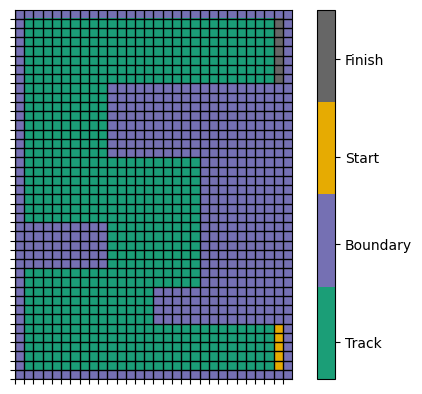

In [5]:
track_left_boundary = [[0, i] for i in range(40)]
track_right_boundary = [[29, i] for i in range(40)]
track_top_boundary = [[i, 39] for i in range(30)]

track_bottom_boundary = [[i, 0] for i in range(30)]
track_starting_line = [[28, i] for i in range(1,6)]
track_finish_line = [[28, i] for i in range(32,39)]
track_boundaries = track_left_boundary + track_right_boundary + track_top_boundary + track_bottom_boundary

bound1 = [[i,j] for i in range(15,30) for j in range(6,10)]
bound2 = [[i,j] for i in range(1,10) for j in range(12,17)]
bound3 = [[i,j] for i in range(20,30) for j in range(10,32)]
bound4 = [[i,j] for i in range(10,20) for j in range(24,32)]
track_boundaries += bound1
track_boundaries += bound2
track_boundaries += bound3
track_boundaries += bound4

racetrack_hardest = Racetrack(track_starting_line, track_finish_line, track_boundaries)
track_map = racetrack_hardest.display_track()

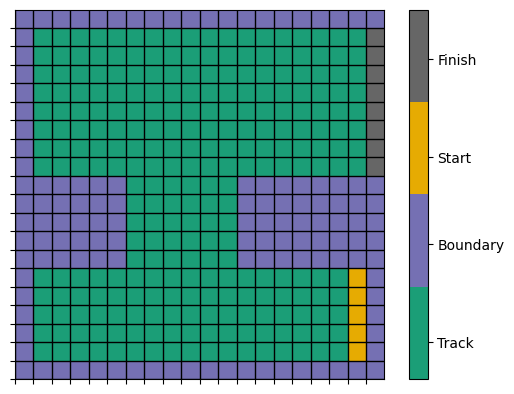

In [6]:
track_left_boundary = [[0, i] for i in range(20)]
track_right_boundary = [[19, i] for i in range(13)]
track_right_boundary += [[j, i] for i in range(6,11) for j in range(1,6)]
track_right_boundary += [[j, i] for i in range(6,11) for j in range(12,19)]
track_top_boundary = [[i, 19] for i in range(20)]

track_bottom_boundary = [[i, 0] for i in range(20)]
track_starting_line = [[18, i] for i in range(1,6)]
track_finish_line = [[19, i] for i in range(11,19)]

racetrack_harder = Racetrack(track_starting_line, track_finish_line, track_left_boundary + track_right_boundary + track_top_boundary + track_bottom_boundary)
track_map = racetrack_harder.display_track()

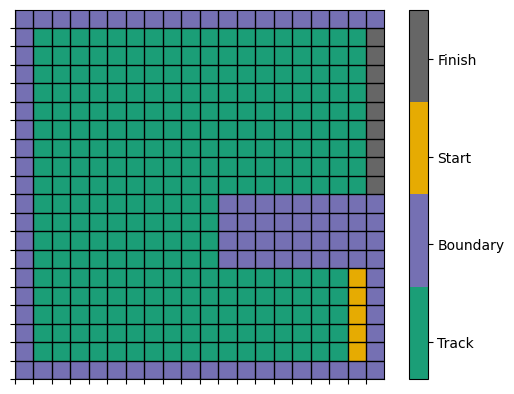

In [7]:
track_left_boundary = [[0, i] for i in range(20)]
track_right_boundary = [[19, i] for i in range(13)]
track_right_boundary += [[j, i] for i in range(6,10) for j in range(11,19)]
track_top_boundary = [[i, 19] for i in range(20)]

track_bottom_boundary = [[i, 0] for i in range(20)]
track_starting_line = [[18, i] for i in range(1,6)]
track_finish_line = [[19, i] for i in range(10,19)]

racetrack_hard = Racetrack(track_starting_line, track_finish_line, track_left_boundary + track_right_boundary + track_top_boundary + track_bottom_boundary)
track_map = racetrack_hard.display_track()


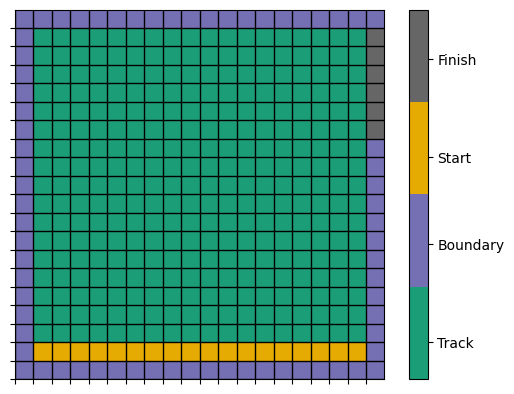

In [8]:
track_right_boundary = [[19, i] for i in range(13)]
track_top_boundary = [[i, 19] for i in range(20)]

track_bottom_boundary = [[i, 0] for i in range(20)]
track_starting_line = [[i, 1] for i in range(1,19)]
track_finish_line = [[19, i] for i in range(13,19)]

racetrack_easy = Racetrack(track_starting_line, track_finish_line, track_left_boundary + track_right_boundary + track_top_boundary + track_bottom_boundary)
track_map = racetrack_easy.display_track()

# off policy control

actions = -1, 0, 1 to both directions, so 9 actions

In [9]:
def make_episode(actions, racetrack: Racetrack, car: Car, policy, epsilon=0.1):
    episode_end = False
    states = []
    actions_seen = []
    rewards = []
    probs = []
    while not episode_end:
        state = (car.x, car.y, car.v_x, car.v_y)
        if np.random.rand() > epsilon and car.check_valid(actions[policy[state]]):
            possible_actions = car.possible_actions()
            action = actions[policy[state]]
            probs.append(1 - epsilon + epsilon/len(possible_actions))
        else:
            action = actions[np.random.randint(len(actions))]
            probs.append(epsilon/len(actions))
            
        states.append(state)
        actions_seen.append(action)
        car.update_velocity(*action)
        rewards.append(-1)
        episode_end = car.update_position(racetrack)

    rewards.append(0)
    return states, actions_seen, rewards, probs



In [10]:
racetrack = racetrack_harder

In [11]:
actions = [(x,y) for x in range(-1,2) for y in range(-1,2)]
q_val = defaultdict(lambda: np.random.rand()*400-500)
cum_weights = defaultdict(lambda: 0)

all_states = [(x, y, v_x, v_y) for x in range(racetrack.max_x) for y in range(racetrack.max_y) for v_x in range(-5,6) for v_y in range(-5,6)]

policy = {state: np.argmax([q_val[state, action] for action in actions]) for state in all_states}


episodes = int(100000)
epsilon = 0.1
gamma = 1
episode_rewards = []
stuff = []
for i in tqdm(range(episodes)):
    car = Car(0, 0, 0, 0)
    car.x, car.y = racetrack.draw_start_point()
    G = 0
    W = 1

    states, actions_seen, rewards, action_prob = make_episode(actions, racetrack, car, policy, epsilon)
    episode_rewards.append(np.sum(rewards))

    for j,t in enumerate(range(len(states)-1, -1, -1)):
        reward = rewards[t+1]
        action = actions_seen[t]
        state = states[t]
        G = gamma * G + reward
        cum_weights[state, action] += W
        q_val[state, action] += W/cum_weights[state, action] * (G - q_val[state, action])
        policy[state] = np.argmax([q_val[state, action] for action in actions])
        if action != actions[policy[state]]:
            break
        W /= (1-epsilon + epsilon/action_prob[t])
    

    stuff.append(j)
    if i % int(episodes/20) == 0:
        print(f'Episode: {i}, Reward: {np.average(episode_rewards[-int(episodes/20):-1])}')


  0%|          | 0/100000 [00:00<?, ?it/s]/Users/fxg433/opt/anaconda3/envs/rl/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/fxg433/opt/anaconda3/envs/rl/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 8/100000 [00:05<13:02:18,  2.13it/s] 

Episode: 0, Reward: nan


  5%|▌         | 5032/100000 [00:26<06:14, 253.47it/s]

Episode: 5000, Reward: -48.835567113422684


 10%|█         | 10039/100000 [00:45<04:10, 359.45it/s]

Episode: 10000, Reward: -24.369473894778956


 15%|█▌        | 15058/100000 [00:58<03:27, 410.12it/s]

Episode: 15000, Reward: -22.674134826965393


 20%|██        | 20096/100000 [01:10<02:34, 518.70it/s]

Episode: 20000, Reward: -21.229045809161832


 25%|██▌       | 25078/100000 [01:21<02:15, 554.85it/s]

Episode: 25000, Reward: -20.07101420284057


 30%|███       | 30096/100000 [01:29<02:06, 550.90it/s]

Episode: 30000, Reward: -18.974794958991797


 35%|███▌      | 35074/100000 [01:38<01:47, 606.51it/s]

Episode: 35000, Reward: -18.45489097819564


 40%|████      | 40110/100000 [01:48<01:54, 524.45it/s]

Episode: 40000, Reward: -17.623324664932987


 45%|████▌     | 45075/100000 [01:57<01:39, 553.23it/s]

Episode: 45000, Reward: -16.638327665533108


 50%|█████     | 50073/100000 [02:06<01:23, 596.57it/s]

Episode: 50000, Reward: -16.089217843568715


 55%|█████▌    | 55079/100000 [02:15<01:15, 597.05it/s]

Episode: 55000, Reward: -15.935387077415482


 60%|██████    | 60054/100000 [02:23<01:18, 508.65it/s]

Episode: 60000, Reward: -15.604120824164832


 65%|██████▌   | 65122/100000 [02:32<00:57, 603.62it/s]

Episode: 65000, Reward: -15.348269653930787


 70%|███████   | 70063/100000 [02:40<00:51, 583.92it/s]

Episode: 70000, Reward: -14.8999799959992


 75%|███████▌  | 75093/100000 [02:48<00:41, 595.29it/s]

Episode: 75000, Reward: -14.87117423484697


 80%|████████  | 80075/100000 [02:55<00:29, 666.84it/s]

Episode: 80000, Reward: -14.81996399279856


 85%|████████▌ | 85090/100000 [03:04<00:25, 593.60it/s]

Episode: 85000, Reward: -14.681336267253451


 90%|█████████ | 90079/100000 [03:12<00:16, 601.21it/s]

Episode: 90000, Reward: -14.52250450090018


 95%|█████████▌| 95080/100000 [03:21<00:08, 567.25it/s]

Episode: 95000, Reward: -14.454090818163634


100%|██████████| 100000/100000 [03:28<00:00, 478.66it/s]


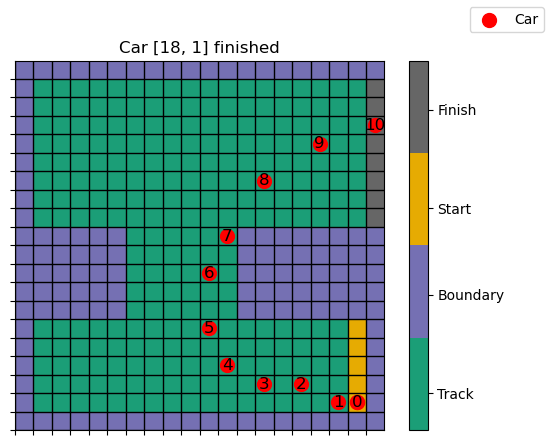

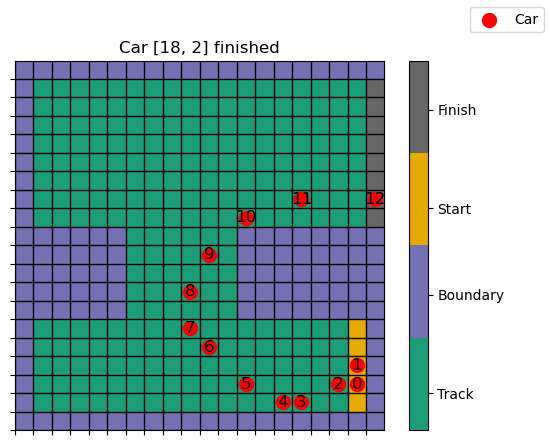

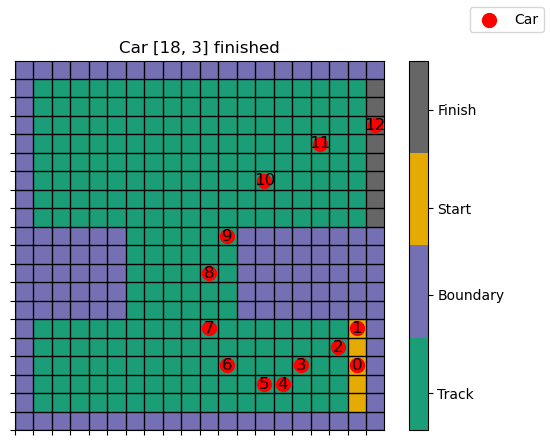

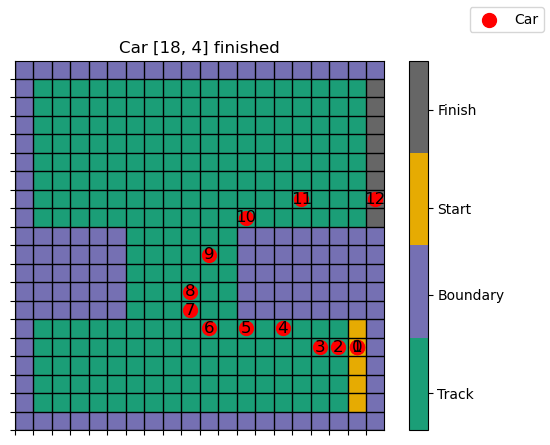

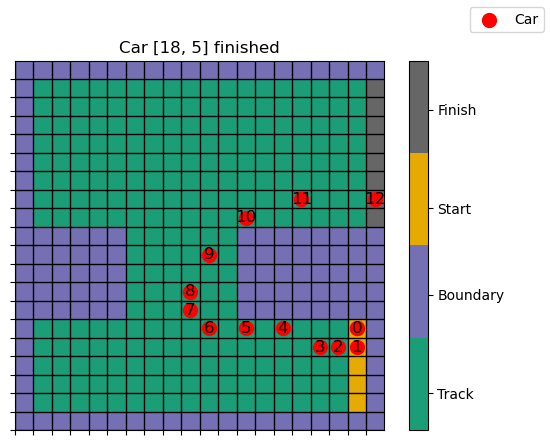

In [13]:
car = Car(4, 1, 0, 0)
for starting_pos in racetrack.starting_line:
    car.x, car.y = starting_pos
    state = (car.x, car.y, car.v_x, car.v_y)
    finished = False 
    positions = [[car.x, car.y]]    
    for i in range(20):
        ac_policy = policy[state]
        action = actions[ac_policy]
        car.update_velocity(*action)
        finished = car.update_position(racetrack)
        
        state = (car.x, car.y, car.v_x, car.v_y)
        positions.append([car.x, car.y])
        if finished:
            fig, ax = racetrack.display_track(positions)
            ax.set_title(f'Car {starting_pos} finished')
            break
        
    if not finished:
        fig, ax = racetrack.display_track(positions)
        ax.set_title(f'Car {starting_pos} not finished')
        
    # 